<a href="https://colab.research.google.com/github/augustinechang1/reinforcement-learning-stock-trade/blob/master/qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random


Using TensorFlow backend.


Reinforcement Learning & Q Learning Algorithms

https://towardsdatascience.com/reinforcement-learning-with-python-8ef0242a2fa2
https://keon.io/deep-q-learning/
https://medium.freecodecamp.org/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe
https://shuaiw.github.io/2018/02/11/teach-machine-to-trade.html
https://www.intel.ai/demystifying-deep-reinforcement-learning/#gs.aunwpv

Code Reference

https://github.com/augustinechang1/q-trader/blob/master/train.py
https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/5.q-learning-agent.ipynb
https://github.com/pskrunner14/trading-bot/blob/master/agent.py

In [5]:
!pip install alpha_vantage

In [0]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [93]:
ts = TimeSeries(key='X5AYBIDIH2EVGNW9', output_format='pandas')
stock, meta_data = ts.get_daily(symbol='DJIA', outputsize='full')
stock = stock['4. close']
df = pd.DataFrame({'Date':stock.index, 'Close':stock.values})
df.head()

,Date,Close
0,2000-01-03,11357.5098
1,2000-01-04,10997.9297
2,2000-01-05,11122.6504
3,2000-01-06,11253.2598
4,2000-01-07,11522.5596


In [94]:
df.iloc[-1:]

,Date,Close
4873,2019-05-17,25764.0


In [0]:
#Set Index Datetime
def equalizestock(time):
#     time.index = pd.to_datetime(time.index)
    if time.index.name != 'Date':
        time = time.set_index('Date')
        time = time.loc['2018-05-10':'2019-05-10']
        return time
    else:
        time = time.loc['2018-05-10':'2019-05-10']
        return time

In [0]:
stock = equalizestock(df)

In [97]:
stock.head()

,Close
Date,
2018-05-10,24739.5293
2018-05-11,24831.1699
2018-05-14,24899.4102
2018-05-15,24706.4102
2018-05-16,24768.9297


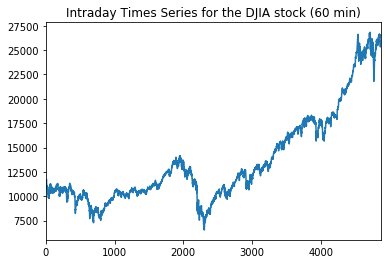

In [98]:
df['Close'].plot()
plt.title('Intraday Times Series for the DJIA stock (60 min)')
plt.show()

In [0]:
class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model(model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay

In [0]:
# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(block[i + 1] - block[i])

	return np.array([res])

In [101]:
data = stock.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
episode_count = 1

agent = Agent(window_size)
l = len(data) - 1
batch_size = 32

for e in range(episode_count + 1):
# 	print ("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			print ("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print ("--------------------------------")
			print ("Total Profit: " + formatPrice(total_profit))
			print ("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		agent.model.save("model_ep" + str(e))

Buy: $24831.17
Buy: $24899.41
Sell: $24706.41 | Profit: -$124.76
Sell: $24768.93 | Profit: -$130.48
Buy: $24713.98
Buy: $25013.29
Sell: $24886.81 | Profit: $172.83
Buy: $24811.76
Buy: $24753.09
Buy: $24361.45
Sell: $24667.78 | Profit: -$345.51
Sell: $24415.84 | Profit: -$395.92
Sell: $24635.21 | Profit: -$117.88
Buy: $25146.39
Sell: $25241.41 | Profit: $879.96
Sell: $25316.53 | Profit: $170.14
Buy: $25322.31
Buy: $25320.73
Buy: $25090.48
Sell: $24987.47 | Profit: -$334.84
Buy: $24461.70
Buy: $24580.89
Sell: $24283.11 | Profit: -$1037.62
Buy: $24117.59
Sell: $24271.41 | Profit: -$819.07
Buy: $24307.18
Sell: $24174.82 | Profit: -$286.88
Buy: $24356.74
Buy: $24456.48
Sell: $24776.59 | Profit: $195.70
Sell: $24919.66 | Profit: $802.07
Sell: $24924.89 | Profit: $617.71
Sell: $25019.41 | Profit: $662.67
Sell: $25064.36 | Profit: $607.88
Buy: $25502.18
Buy: $25628.91
Sell: $25187.70 | Profit: -$314.48
Buy: $25299.92
Sell: $25162.41 | Profit: -$466.50
Sell: $25758.69 | Profit: $458.77
Buy: $25

In [102]:
model_name = 'model_ep0'
model = load_model(model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = stock.Close.values.tolist()
l = len(data) - 1
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
# starting_money = initial_money
states_sell = []
states_buy = []
agent.inventory = []

for t in range(l):
  action = agent.act(state)

  # sit
  next_state = getState(data, t + 1, window_size + 1)
  reward = 0

  if action == 1: # buy
    agent.inventory.append(data[t])
    states_buy.append(t)
    print ("Buy: " + formatPrice(data[t]))

  elif action == 2 and len(agent.inventory) > 0: # sell
    bought_price = agent.inventory.pop(0)
    reward = max(data[t] - bought_price, 0)
    total_profit += data[t] - bought_price
    states_sell.append(t)
    print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

  done = True if t == l - 1 else False
  agent.memory.append((state, action, reward, next_state, done))
  state = next_state

  if done:
    print ("--------------------------------")
    print (" Total Profit: " + formatPrice(total_profit))
    print ("--------------------------------")

Buy: $24739.53
Sell: $24831.17 | Profit: $91.64
Buy: $24706.41
Buy: $24768.93
Buy: $24713.98
Buy: $24715.09
Sell: $25013.29 | Profit: $306.88
Buy: $24834.41
Sell: $24886.81 | Profit: $117.88
Buy: $24811.76
Buy: $24753.09
Buy: $24361.45
Buy: $24667.78
Buy: $24415.84
Buy: $24635.21
Sell: $24813.69 | Profit: $99.71
Sell: $24799.98 | Profit: $84.89
Sell: $25146.39 | Profit: $311.98
Sell: $25241.41 | Profit: $429.65
Sell: $25316.53 | Profit: $563.44
Buy: $25322.31
Buy: $25320.73
Buy: $25201.20
Buy: $25175.31
Buy: $25090.48
Sell: $24987.47 | Profit: $626.02
Buy: $24700.21
Buy: $24657.80
Buy: $24461.70
Buy: $24580.89
Buy: $24252.80
Sell: $24283.11 | Profit: -$384.67
Buy: $24117.59
Buy: $24216.05
Sell: $24271.41 | Profit: -$144.43
Buy: $24307.18
Sell: $24174.82 | Profit: -$460.39
Buy: $24356.74
Buy: $24456.48
Sell: $24776.59 | Profit: -$545.72
Sell: $24919.66 | Profit: -$401.07
Sell: $24700.45 | Profit: -$500.75
Sell: $24924.89 | Profit: -$250.42
Sell: $25019.41 | Profit: -$71.07
Sell: $25064.

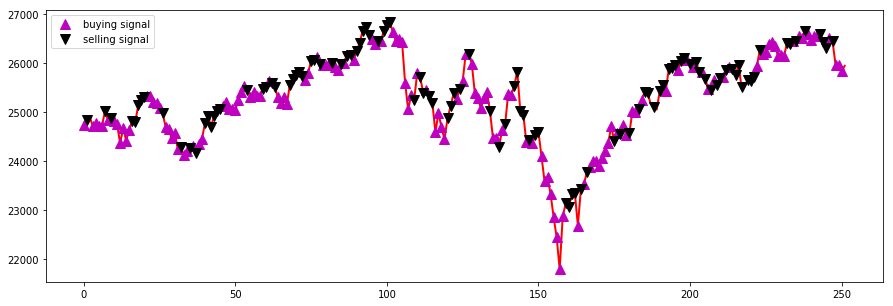

In [103]:
fig = plt.figure(figsize = (15,5))
plt.plot(data, color='r', lw=2.)
plt.plot(data, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(data, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()